<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-10 16:36:46.860316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 16:36:49.271285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-10 16:36:49.272600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-10 16:36:49.273835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-10 16:36:52,365[INFO][140253230147392-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

# generate datasets
train_size= 40 #@param {type:"integer"}
test_size = 2  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_source = '/cic/dataset/normalized_labeled/nsm-huongftp-v2-label/' #@param {type:"string"}
L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()'])
predict_size = total_size // n_timesteps_in
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_count

label  count()
0    0.0     7632
1    1.0       16

## Data preview

### L_train preview

In [5]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0       0.0           0.0         0.0          0.0         0.0         0.0   
1       0.0           0.0         0.0          0.0         0.0         0.0   
2       0.0           0.0         0.0          0.0         0.0         0.0   
3       0.0           0.0         0.0          0.0         0.0         0.0   
4       0.0           0.0         0.0          0.0         0.0         0.0   
...     ...           ...         ...          ...         ...         ...   
7595    0.0           0.0         0.0          0.0         0.0         0.0   
7596    0.0           0.0         0.0          0.0         0.0         0.0   
7597    0.0           0.0         0.0          0.0         0.0         0.0   
7598    0.0           0.0         0.0          0.0         0.0         0.0   
7599    0.0           0.0         0.0          0.0         0.0         0.0   

      bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                  0.0             0.0             0.0          0.0   
1                  0.0             0.0             0.0          0.0   
2                  0.0             0.0             0.0          0.0   
3                  0.0             0.0             0.0          0.0   
4                  0.0             0.0             0.0          0.0   
...                ...             ...             ...          ...   
7595               0.0             0.0             1.0          1.0   
7596               0.0             0.0             1.0          0.0   
7597               0.0             0.0             1.0          0.0   
7598               1.0             1.0             1.0          1.0   
7599               0.0             0.0             1.0          1.0   

      bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0              0.0     0.000000          0.0          0.0              0.0   
1              0.0     0.000000          0.0          0.0              0.0   
2              0.0     0.000000          0.0          0.0              0.0   
3              0.0     0.000000          0.0          0.0              0.0   
4              0.0     0.000000          0.0          0.0              0.0   
...            ...          ...          ...          ...              ...   
7595           1.0     1.000000          1.0          1.0              1.0   
7596           0.0     0.000000          0.0          0.0              1.0   
7597           0.0     0.000000          0.0          0.0              1.0   
7598           1.0     0.999988          1.0          1.0              1.0   
7599           1.0     1.000000          1.0          1.0              1.0   

      bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                  0.0              0.0              0.0             0.0   
1                  0.0              0.0              0.0             0.0   
2                  0.0              0.0              0.0             0.0   
3                  0.0              0.0              0.0             0.0   
4                  0.0              0.0              0.0             0.0   
...                ...              ...              ...             ...   
7595               1.0              1.0              0.0             0.0   
7596               1.0              1.0              0.0             0.0   
7597               1.0              1.0              0.0             0.0   
7598               1.0              1.0              1.0             1.0   
7599               1.0              1.0              1.0             0.0   

      bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0       0.000000            0.0               0.0            0.0   
1       0.000000            0.0               0.0            0.0   
2       0.000000            0.0               0.0            0.0   
3       0.000000            0.0               0.0            0.0   
4       0.000000          

In [6]:
L_predict[[LABEL, *features]].describe()

label  ack_flag_cnt   active_max  active_mean   active_min  \
count  7600.000000        7600.0  7600.000000  7600.000000  7600.000000   
mean      0.002105           0.0     0.109474     0.109474     0.109473   
std       0.045838           0.0     0.312253     0.312253     0.312251   
min       0.000000           0.0     0.000000     0.000000     0.000000   
25%       0.000000           0.0     0.000000     0.000000     0.000000   
50%       0.000000           0.0     0.000000     0.000000     0.000000   
75%       0.000000           0.0     0.000000     0.000000     0.000000   
max       1.000000           0.0     1.000000     1.000000     1.000000   

        active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  7600.000000       7600.000000     7600.000000     7600.000000   
mean      0.109474          0.143026        0.143026        0.696974   
std       0.312253          0.350123        0.350123        0.459597   
min       0.000000          0.000000        0.000000        0.000000   
25%       0.000000          0.000000        0.000000        0.000000   
50%       0.000000          0.000000        0.000000        1.000000   
75%       0.000000          0.000000        0.000000        1.000000   
max       1.000000          1.000000        1.000000        1.000000   

       bwd_iat_max  bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  \
count  7600.000000   7600.000000  7600.000000  7600.000000  7600.000000   
mean      0.404868      0.404868     0.386126     0.404865     0.404868   
std       0.490899      0.490899     0.499255     0.490895     0.490899   
min       0.000000      0.000000    -1.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       1.000000      1.000000     1.000000     1.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count      7600.000000       7600.000000      7600.000000      7600.000000   
mean          0.696974          0.696974         0.696974         0.399349   
std           0.459597          0.459597         0.459597         0.489143   
min           0.000000          0.000000         0.000000         0.000000   
25%           0.000000          0.000000         0.000000         0.000000   
50%           1.000000          1.000000         1.000000         0.000000   
75%           1.000000          1.000000         1.000000         1.000000   
max           1.000000          1.000000         1.000000         1.000000   

       bwd_pkts_b_avg   bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count     7600.000000  7600.000000         7600.0       7600.000000   
mean         0.142964     0.639231            0.0          0.696974   
std          0.349969     0.458346            0.0          0.459597   
min          0.000000     0.000000            0.0          0.000000   
25%          0.000000     0.000000            0.0          0.000000   
50%          0.000000     1.000000            0.0          1.000000   
75%          0.000000     1.000000            0.0          1.000000   
max          1.000000     1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count         7600.0          7600.0    7600.000000    7600.0        7600.0   
mean             0.0             0.0       0.536954       1.0           0.0   
std              0.0             0.0       0.376897       0.0           0.0   
min              0.0             0.0       0.000000       1.0           0.0   
25%              0.0             0.0       0.000000       1.0           0.0   
50%              0.0             0.0       0.761594       1.0           0.0   
75%              0.0             0.0       0.804455       1.0           0.0   
max              0.0             0.0 

In [7]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     15   16   17   18   19   20   21   22   23   24   25        26   27   28  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   

     29   30   31   32   33        34   35   36   37   38   39   40   41   42  \
0   1.0  1.0  1.0  1.0  1.0  0.964028  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
1   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
2   1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
4   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
..  ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
96  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
97  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
98  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
99  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   

     43   44   45   46   47   48   49   50   51   52   53   54   55   56   57  \
0   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
99  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

     58   59   60   61   62   63   64        65   66   67   68   69   70   71  \
0   1.0  1.0  1.0  1.0  1.0  1.0

In [8]:
DataFrame.from_records(LX_predict[0]).describe()

0      1      2      3      4           5           6          7   \
count  100.0  100.0  100.0  100.0  100.0  100.000000  100.000000  100.00000   
mean     0.0    0.0    0.0    0.0    0.0    0.020000    0.020000    0.08000   
std      0.0    0.0    0.0    0.0    0.0    0.140705    0.140705    0.27266   
min      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
25%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
50%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
75%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
max      0.0    0.0    0.0    0.0    0.0    1.000000    1.000000    1.00000   

               8           9           10          11          12         13  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
mean     0.030000    0.030000    0.020000    0.030000    0.030000    0.08000   
std      0.171447    0.171447    0.140705    0.171447    0.171447    0.27266   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.00000   

              14         15          16          17          18     19  \
count  100.00000  100.00000  100.000000  100.000000  100.000000  100.0   
mean     0.08000    0.08000    0.040000    0.019999    0.079999    0.0   
std      0.27266    0.27266    0.196946    0.140699    0.272658    0.0   
min      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
25%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
50%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
75%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
max      1.00000    1.00000    1.000000    1.000000    1.000000    0.0   

              20     21     22          23     24     25          26     27  \
count  100.00000  100.0  100.0  100.000000  100.0  100.0  100.000000  100.0   
mean     0.08000    0.0    0.0    0.059179    1.0    0.0    0.738746    1.0   
std      0.27266    0.0    0.0    0.204028    0.0    0.0    0.130573    0.0   
min      0.00000    0.0    0.0    0.000000    1.0    0.0    0.000000    1.0   
25%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
50%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
75%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
max      1.00000    0.0    0.0    0.828775    1.0    0.0    0.761594    1.0   

          28          29          30          31          32          33  \
count  100.0  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.0    0.970000    0.970000    0.957241    0.970000    0.987223   
std      0.0    0.171447    0.171447    0.197849    0.171447    0.073371   
min      1.0    0.000000    0.000000    0.000000    0.000000    0.528532   
25%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   

               34          35          36            37          38  \
count  100.000000  100.000000  100.000000  1.000000e+02  100.000000   
mean     0.792220    0.100000    0.100000  1.000000e+00    0.950000   
std      0.079703    0.301511    0.301511  3.858754e-08    0.219043   
min      0.761594    0.000000    0.000000  9.999998e-01    0.000000   
25%      0.761594    0.000000    0.000000  1.000000e+00    1.000000   
50%      0.761594    0.000000    0.000000  1.000000e+00    1.000000   
75%      0.76159

In [9]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
71  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
72  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
74  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
75  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
71  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
72  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
74  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
75  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
71  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
72  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
74  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
75  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     45   46   47   48   49   50   51   52   53   54   55   56   57   58   59  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
71  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
72  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
74  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
75  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

     60   61   62   63   64   65   66   67   68   69   70   71   72   73   74  \
0   0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
DataFrame.from_records(Ly_predict).describe()

0     1     2     3     4     5     6     7     8     9     10    11  \
count  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0   
mean    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
std     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
min     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
75%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
max     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         12    13    14    15    16    17    18    19    20    21    22    23  \
count  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0   
mean    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
std     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
min     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
75%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
max     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         24    25    26    27    28    29    30    31    32    33    34    35  \
count  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0   
mean    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
std     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
min     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
75%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
max     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         36    37    38    39    40    41    42    43    44    45    46    47  \
count  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.0   
mean    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
std     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
min     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
75%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
max     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         48    49    50    51    52    53    54         55         56  \
count  76.0  76.0  76.0  76.0  76.0  76.0  76.0  76.000000  76.000000   
mean    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.013158   0.013158   
std     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.114708   0.114708   
min     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.000000   
25%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.000000   
50%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.000000   
75%     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.000000   0.000000   
max     0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.000000   1.000000   

              57         58         59         60         61         62  \
count  76.000000  76.000000  76.000000  76.000000  76.000000  76.000000   
mean    0.013158   0.013158   0.013158   0.013158   0.013158   0.013158   
std     0.114708   0.114708   0.114708   0.114708   0.114708   0.114708   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.00

## Data visualization

In [11]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

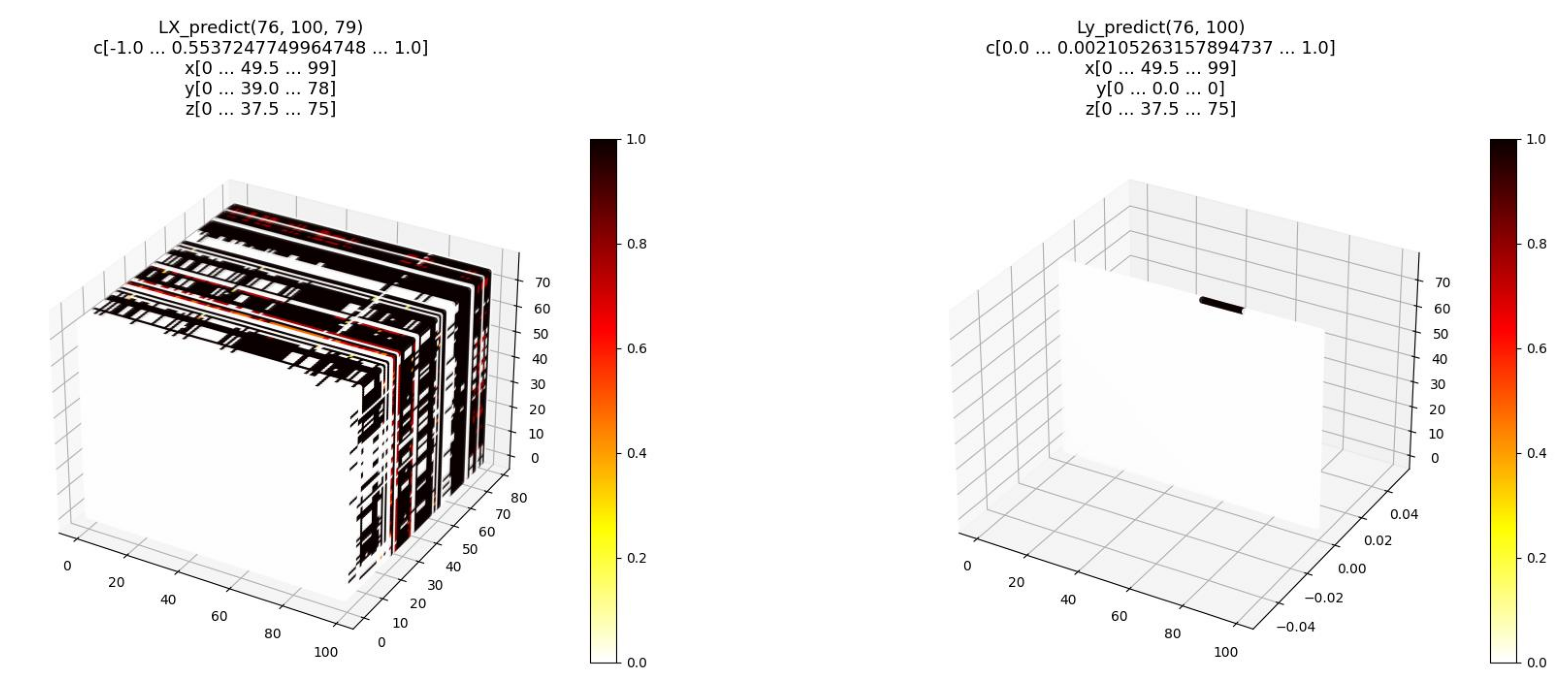

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [13]:
def threshold(num):
    return 1 if num > 0.5 else 0

def infer(name='model', checkpoint='anomaly_flow79_local_ftp_norm'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    print(f"predicted/Ly_predict = {predicted.sum()}/{Ly_predict.sum()}")
    #np.logical_and(predicted.reshape((56,100)), Ly_predict).sum()

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-02-10 16:37:29.547179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-10 16:37:29.548064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-10 16:37:29.548849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-10 16:37:29.549612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


predicted/Ly_predict = 1817/16.0


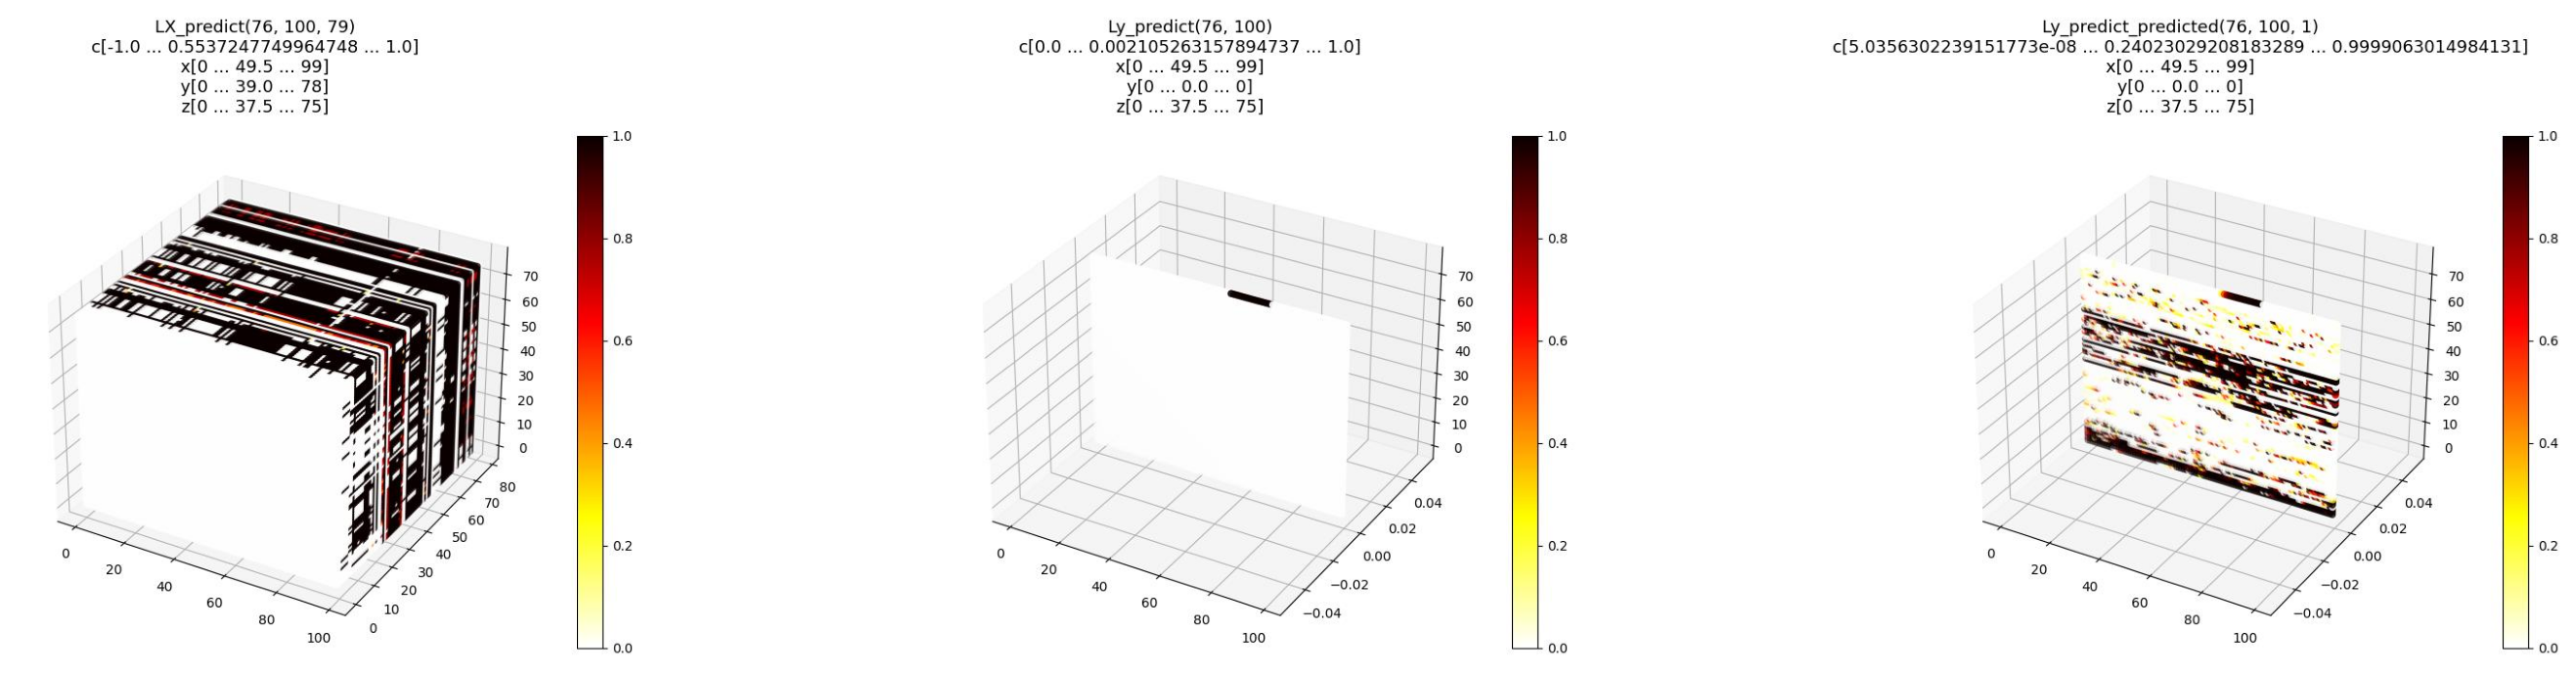

In [14]:
infer('model6', 'anomaly_flow79_local_ftp_norm')

predicted/Ly_predict = 1526/16.0


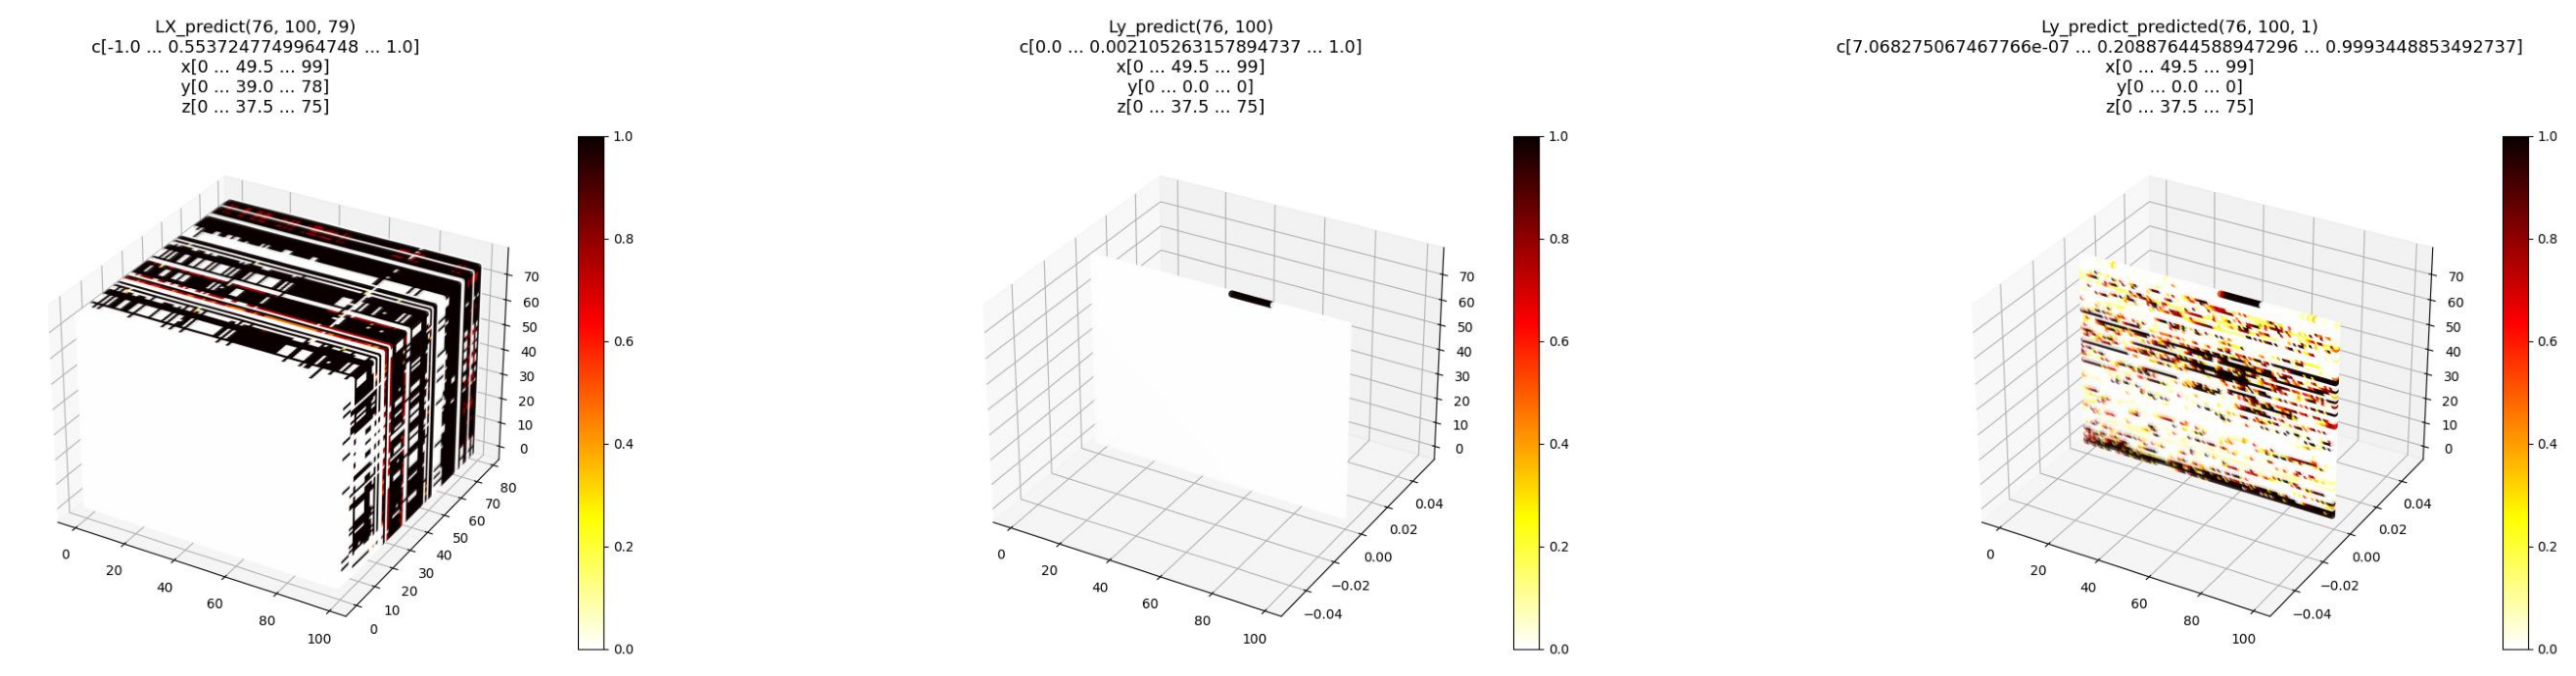

In [15]:
infer('model6', 'anomaly_flow79_local_ssh_transfer_local_ftp_norm')

predicted/Ly_predict = 1166/16.0


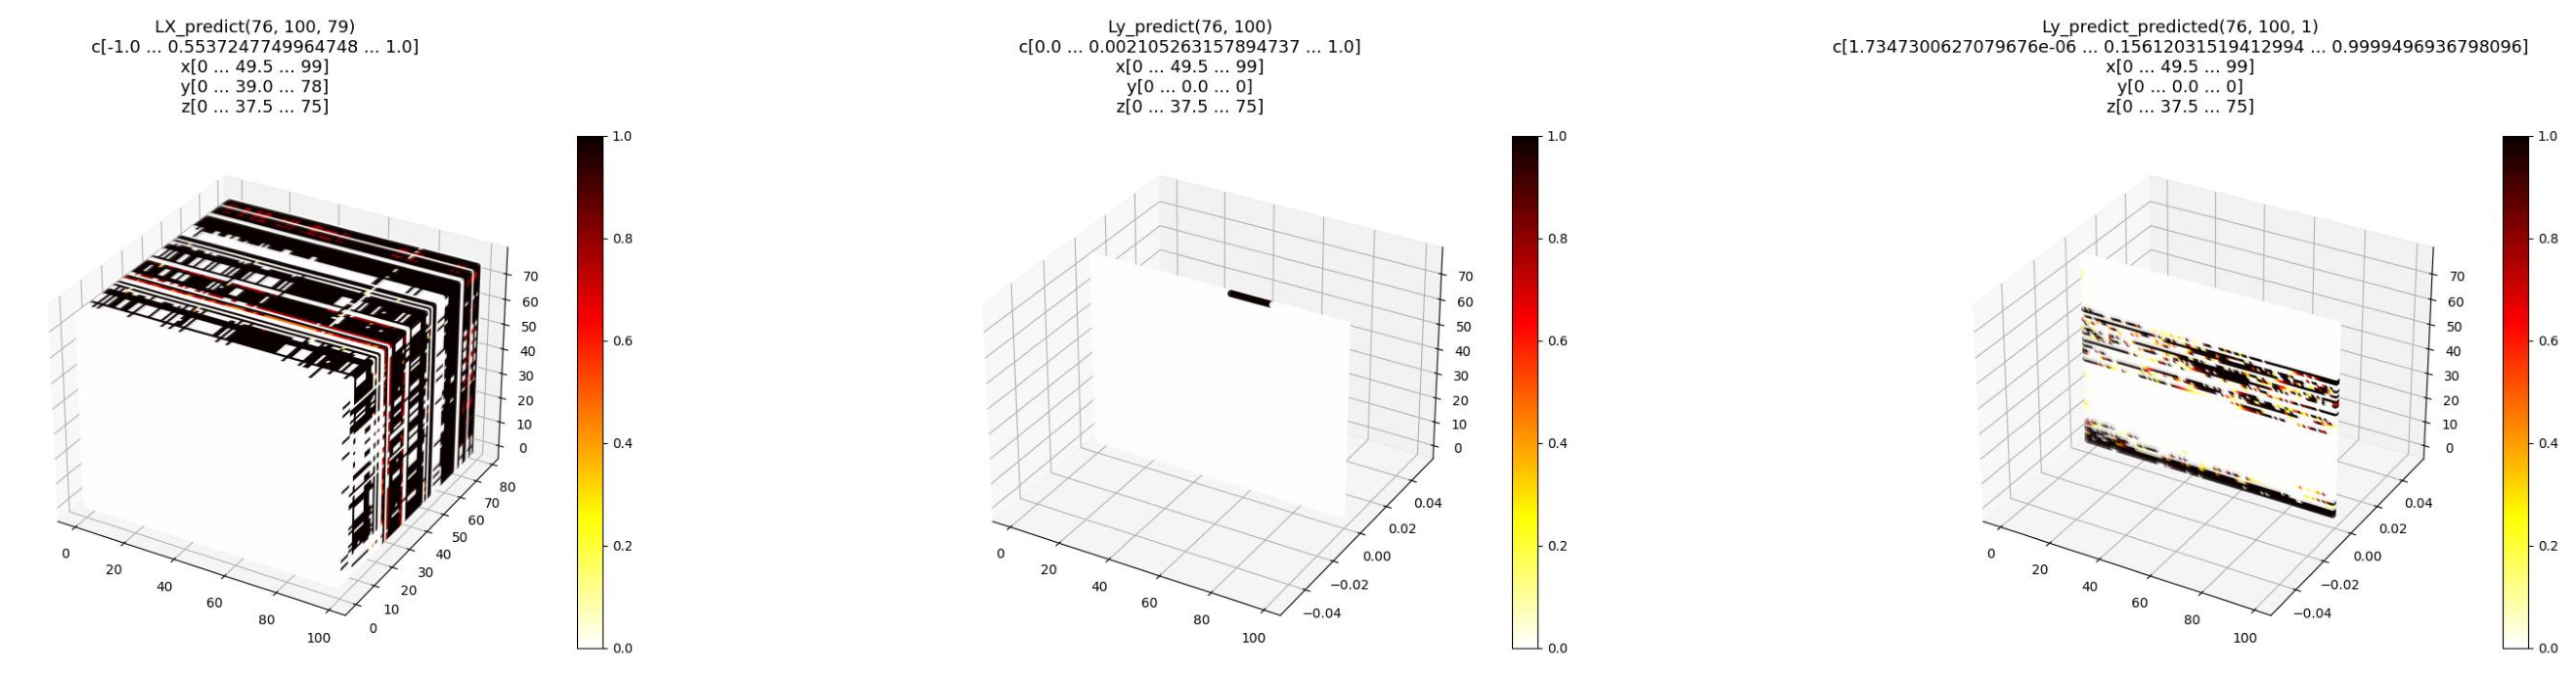

In [16]:
infer('model6', 'anomaly_flow79_local_ftp_transfer_local_ssh_norm')

predicted/Ly_predict = 1950/16.0


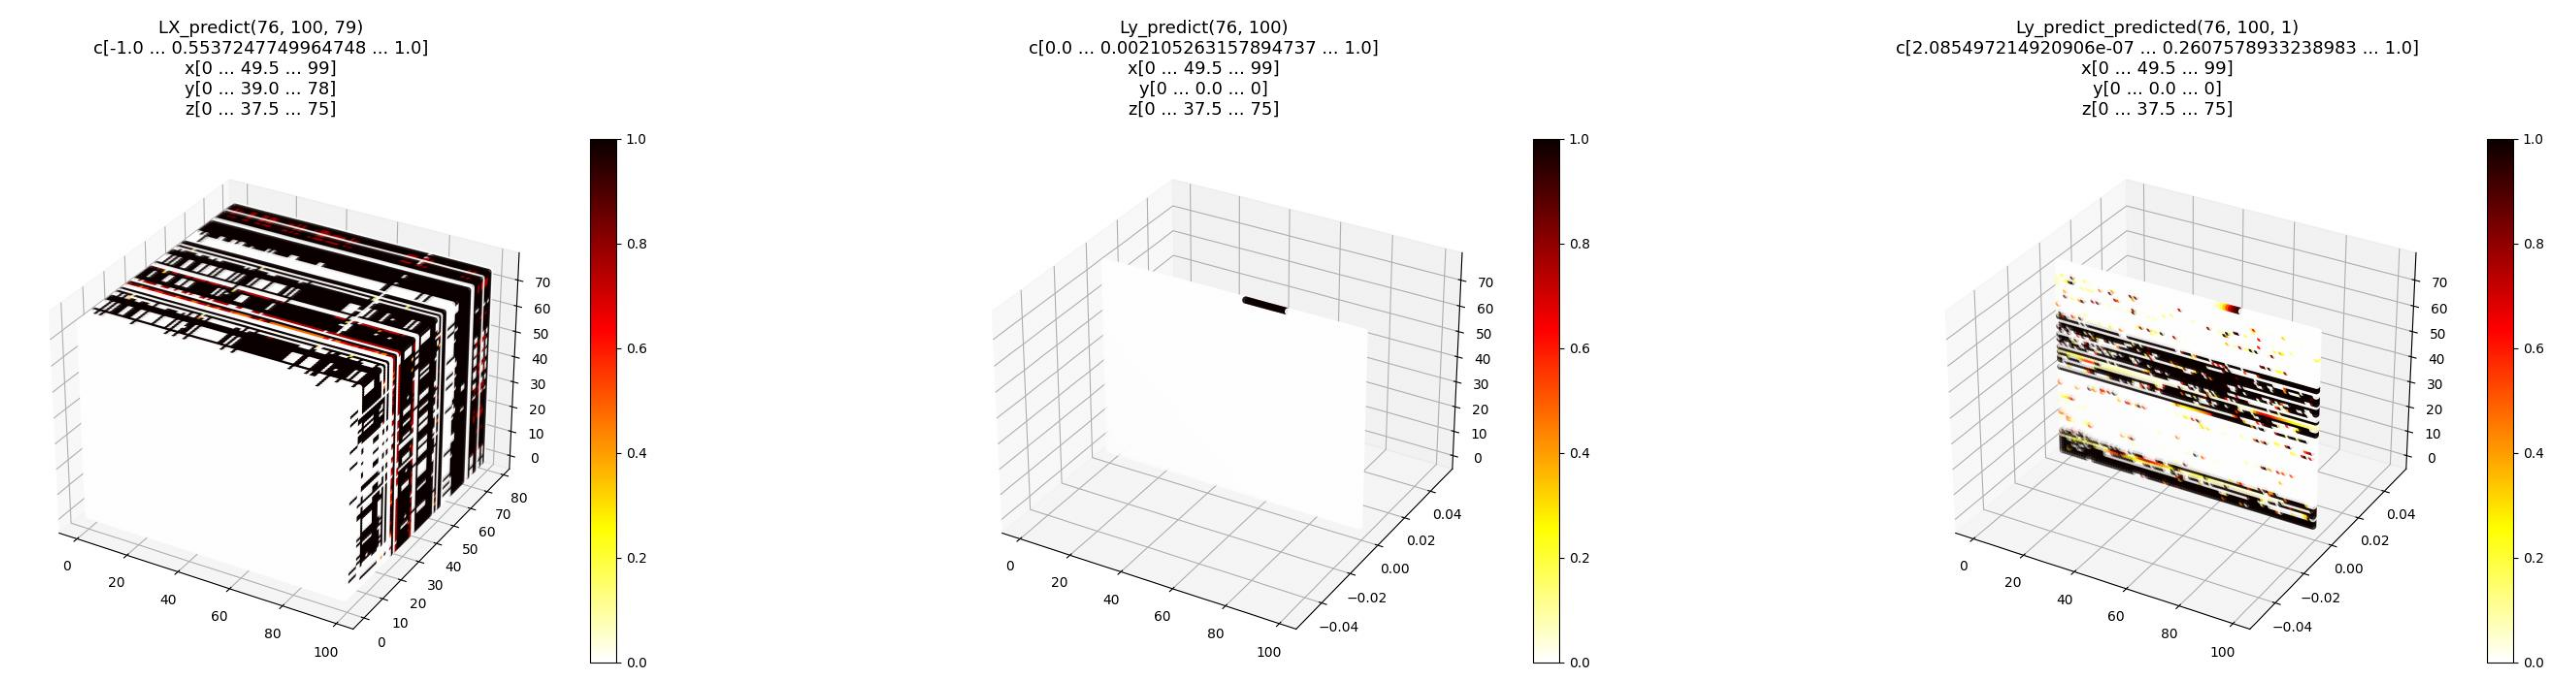

In [17]:
infer('model6', 'anomaly_flow79_local_ftp_ssh_norm')

2023-02-10 16:37:46,912[WARNING][140253230147392-MainThread] def_function.py:called_with_tracing(163) 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f8d80626ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


predicted/Ly_predict = 354/16.0


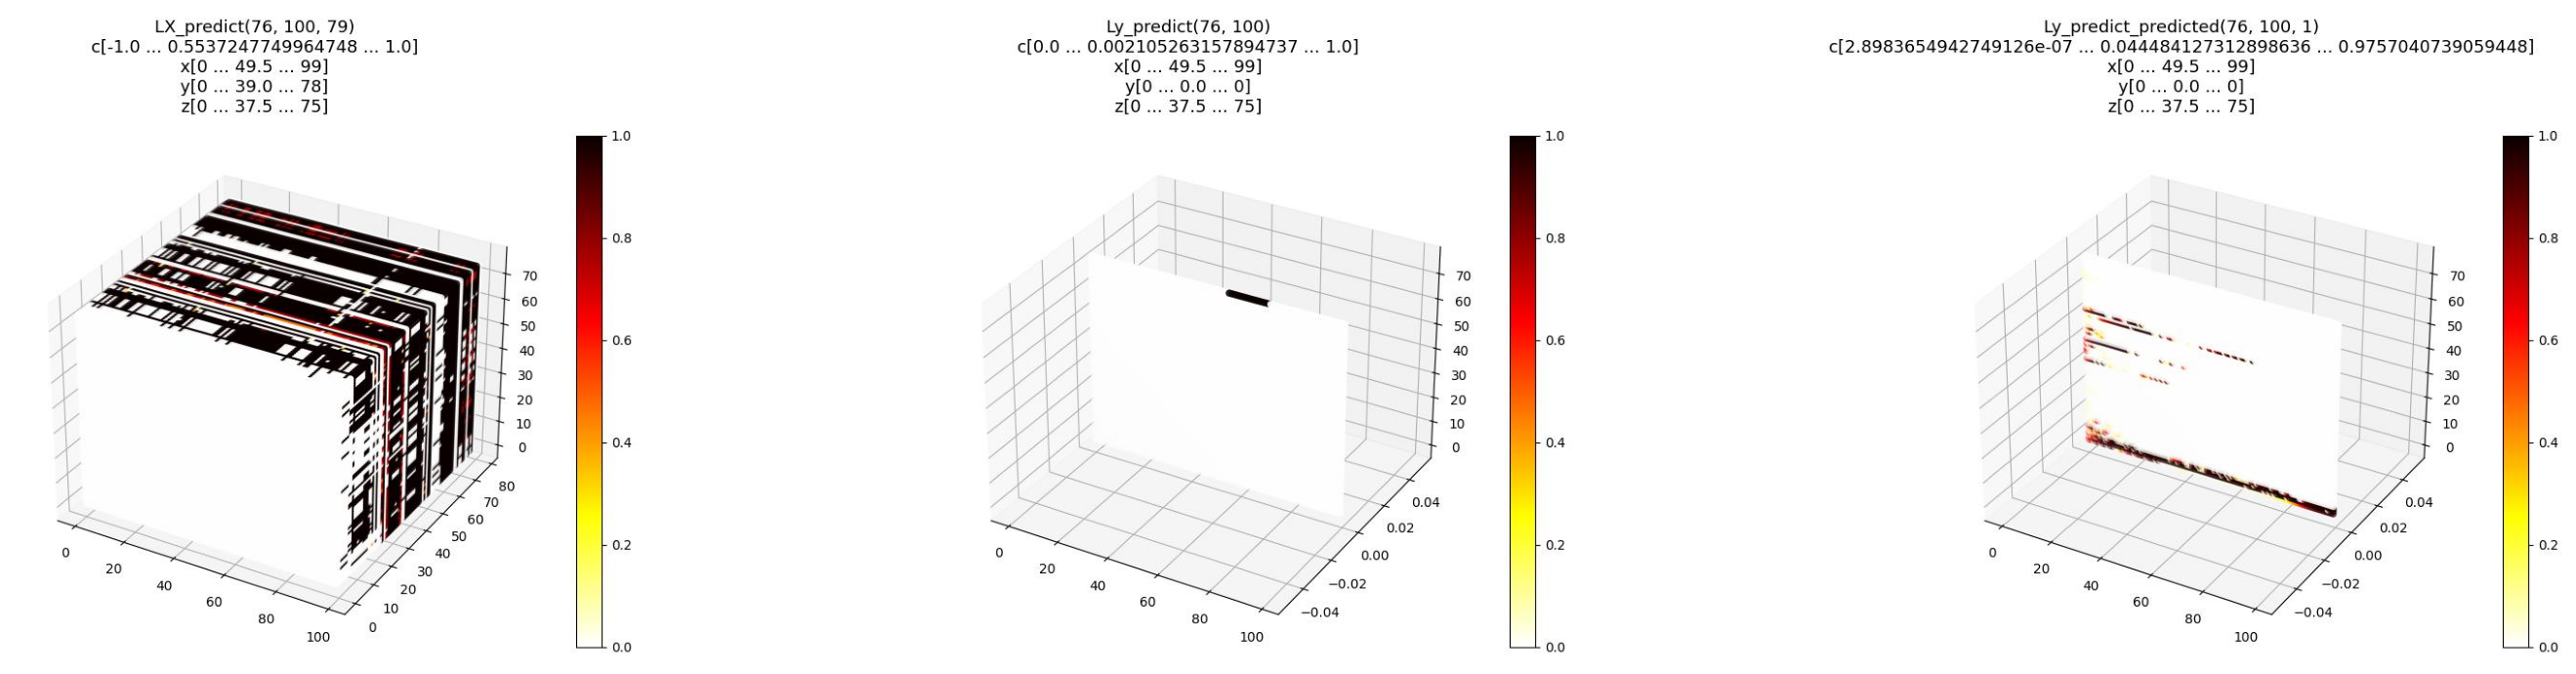

In [18]:
infer('model6', 'anomaly_flow79_local_ssh_norm')

In [19]:
#infer('model6', 'anomaly_flow79_cic_ftp_norm')